In [1]:
%cd ..

/home/jo3/p/features2image_diffusion


/home/jo3/p/features2image_diffusion/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import argtoml
import jax
import matplotlib.pyplot as plt
import numpy as np
import torch

from pathlib import Path
from typing import Tuple

from jaxtyping import Float
from jo3mnist.vis import to_img
from torch.utils.data import DataLoader

from features2image_diffusion.__main__ import evaluate
from features2image_diffusion.data import load_mnist_with_features
from features2image_diffusion.unet import load_ddpm

np.set_printoptions(precision=3)

RUN_PATH = Path.cwd() / "run/7927ad448cfdb96d1e819f599d5ce8a200a3de67068866289c8cf1e0215ec398"
O = argtoml.parse_args(toml_path=RUN_PATH / "config.toml")
RUN = O.run[0]
DEVICE = "cuda"

TRAIN_SET, TEST_SET = load_mnist_with_features(
    RUN.feature_dir, O.mnist_dir, RUN.batch_size, shuffle=False
)

/home/jo3/p/features2image_diffusion/.venv/lib/python3.11/site-packages/jo3util/warning.py:18: ToDoWarning: 'Make sure file names are numeric before the .npy.'
  warnings.warn(msg, ToDoWarning)


In [3]:
def all_features_and_labels(dataset: DataLoader) -> Tuple[
    Float[torch.Tensor, "datapoints features"], 
    Float[torch.Tensor, "datapoints"]
]:
    """ Gather all features and labels into 2 big numpy arrays."""
    all_features = []
    all_labels = []
    for features, _, labels in dataset:
        all_features.append(torch.Tensor(features))
        all_labels.append(torch.Tensor(labels))
    return torch.concatenate(all_features), torch.concatenate(all_labels)

TRAIN_FEATURES, TRAIN_LABELS = all_features_and_labels(TRAIN_SET)
print(TRAIN_FEATURES.shape, TRAIN_LABELS.shape) 

torch.Size([60000, 256]) torch.Size([60000])


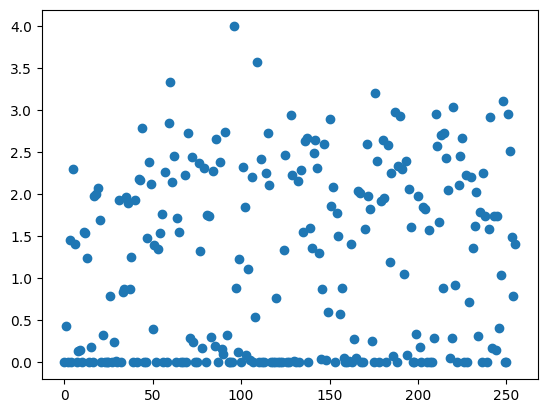

In [4]:
#X = np.log(TRAIN_FEATURES + 1e-20)
TRAIN_FEATURES_AVG = torch.mean(TRAIN_FEATURES, axis=0)
TRAIN_FEATURES_STD = torch.std(TRAIN_FEATURES, axis=0)
plt.scatter(
#plt.errorbar(
    x=np.arange(TRAIN_FEATURES.shape[1]),
    y=TRAIN_FEATURES_AVG,
#    yerr=TRAIN_FEATURES_STD
)

This does not seem very sparse. Let's see how sparse an average datapoint is.

In [5]:
@jax.vmap
def sparsity(point, thresh=0.01):
    return np.sum(point > thresh) / len(point)

SPARSITY = sparsity(np.array(TRAIN_FEATURES))
print(np.mean(SPARSITY).item(), np.std(SPARSITY).item())

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


0.5737580060958862 0.0127316415309906


More than half the features are active for any picture. That's not good, we'll need to run this again sometime.
Let's sort them by variance so we can guide our edits.

In [6]:
FEATURES_SORTED_BY_STD = np.argsort(TRAIN_FEATURES_STD, axis=0)
print(FEATURES_SORTED_BY_STD[-10:])
print(TRAIN_FEATURES_AVG[FEATURES_SORTED_BY_STD][-10:])
print(TRAIN_FEATURES_STD[FEATURES_SORTED_BY_STD][-10:])

tensor([ 60, 190, 150, 180, 251,  96, 215, 142, 176, 128])
tensor([3.3336, 2.9315, 2.8921, 2.6445, 2.9475, 3.9932, 2.7286, 2.6410, 3.2082,
        2.9412])
tensor([1.5774, 1.5966, 1.6343, 1.6751, 1.7339, 1.7395, 1.7496, 1.7693, 1.7746,
        1.7810])


Let's now get an example image.

class = tensor(5)


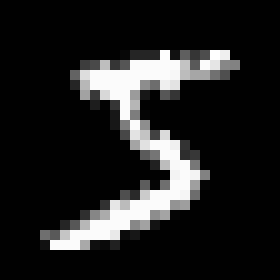

In [7]:
del TRAIN_FEATURES
del TRAIN_LABELS

EXAMPLE = next(iter(TRAIN_SET))
EXAMPLE_FEATURES = torch.unsqueeze(EXAMPLE[0][0], 0)
EXAMPLE_IMAGE = EXAMPLE[1][0]
EXAMPLE_LABEL = EXAMPLE[2][0]

print("class =", EXAMPLE_LABEL)
to_img(EXAMPLE_IMAGE)

And now we let the ddpm generate variations on this image
by conditioning it on the image's features.

In [10]:
DDPM = load_ddpm(
    RUN_PATH / "model/epoch-22.pth",
    EXAMPLE_FEATURES.shape[-1],
    n_T=400,
    device=DEVICE,
    opts=RUN
).eval()

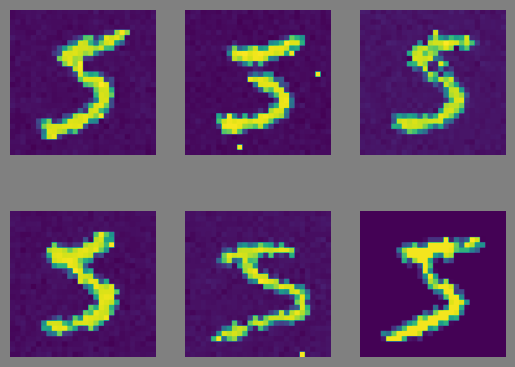

In [40]:
def generate_and_show(
    ddpm,
    features,
    num_generations,
    original_img=None,
    device=DEVICE
):
    # Generate images.
    with torch.no_grad():
        generations, _ = DDPM.sample(
            features,
            num_generations,
            original_img.shape,
            device
        )
    generations = generations.cpu().numpy()

    # Determine the shape of the table of images.
    num_images = num_generations
    if original_img is not None:
        num_images += 1
    rows = int(np.sqrt(num_images))
    cols = num_images // rows
    if rows * cols < num_images:
        cols += 1
    fig, axs = plt.subplots(rows, cols, facecolor="gray")

    # Place the images in the table.
    for i, generation in enumerate(generations):
        r = i // cols
        c = i % cols
        axs[r, c].imshow(to_img(generation))
        axs[r, c].set_axis_off()
    if original_img is not None:
        axs[-1, -1].imshow(to_img(original_img))
        axs[-1, -1].set_axis_off()
    plt.show()

    return generations

_ = generate_and_show(DDPM, EXAMPLE_FEATURES, 5, EXAMPLE_IMAGE)

Those are some crappy generations.  
Let's see how they change as we change the features.
The 128th features had the highest standard deviation, so let's what it is here, and then change it.

tensor(2.8017)



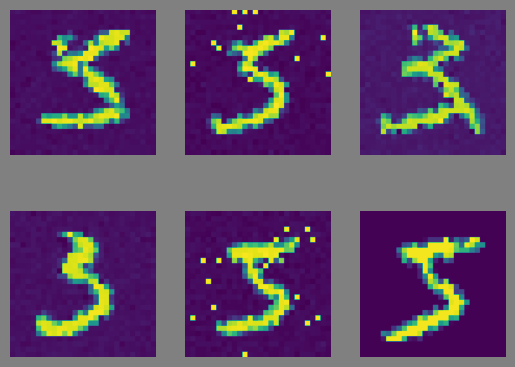

In [49]:
print(EXAMPLE_FEATURES[0, 128])  # That's close to the average.

def edit_features(features, value, *index):
    new_features = features.clone().detach()
    slice = new_features
    for i in index[:-1]:
        slice = slice[i]
    slice[index[-1]] = value
    return new_features

EDITED_FEATURES = edit_features(EXAMPLE_FEATURES, 0.0, 0, 128)
_ = generate_and_show(DDPM, EDITED_FEATURES, 5, EXAMPLE_IMAGE)